In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import optax
from flax import linen as nn
from flax.training import train_state
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import itertools

import jaxmetric as jm
import models

In [2]:
key = jax.random.PRNGKey(0)

psi=0

k_mod = [1,1,1,1]

proj_facts = (1,1,1,1,)

# poly = jit(lambda x: x[0]**5 + x[1]**5 + x[2]**5 +x[3]**5 + x[4]**5 + psi* x[0]*x[1]*x[2]*x[3]*x[4])

psi0 = 0.5
psi1 = 1.

combinations = list(itertools.product([0, 1], repeat=4))

@jit
def poly(x):
    X = jnp.array([x[0],x[1]])
    Y = jnp.array([x[2],x[3]])
    U = jnp.array([x[4],x[5]])
    V = jnp.array([x[6],x[7]])
    term_sum = 0
    term_prod = psi1 * (X[0] * Y[0] * U[0] * V[0]) * (X[1] * Y[1] * U[1] * V[1])
    for c in combinations:
        s = sum(c)
        term_sum += (1-s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2. + psi0*(s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2.

    return term_prod + term_sum

In [3]:
# points = jm.point_gen.generate_points_calabi_yau(key, proj_facts,poly,1e5)


# with open("100kPointsTQ.pkl", "wb") as f:
#     pickle.dump(points, f)


with open("100kPointsTQ.pkl", "rb") as f:
    points = pickle.load(f)


print(jnp.shape(points))

(100000, 8)


In [4]:
# Initialize the model
model = models.FuncQuintic()

# Generate a PRNG key
key = jax.random.PRNGKey(np.random.randint(0,10**6))

# Initialize parameters
params = model.init(key,  jm.complex_numbers.complex_to_real(points[0]))

kappa_val = jm.metrics.kappa(proj_facts,k_mod, poly, points)

print(kappa_val)

1.0145104


In [5]:
# Split points into training and evaluation sets
split_ratio = 0.8
split_index = int(len(points) * split_ratio)
train_points = points[:split_index]
eval_points = points[split_index:]

def batch_data(data, batch_size):
    num_batches = len(data) // batch_size
    return jnp.array_split(data[:num_batches * batch_size], num_batches)

ptsBatched = batch_data(train_points, 1000)

ptsBatched[0].shape,len(ptsBatched)

((1000, 8), 80)

In [ ]:
jm.metrics.ricci_curvature_amb(model, params, proj_facts, k_mod,jnp.array([ptsBatched[0][0]]))

In [8]:
jm.metrics.cy_metric(model, params,proj_facts,k_mod,poly, ptsBatched[0])

Array([[[-0.57528716+1.4901161e-08j,  0.75774753+4.4981232e-01j,
         -0.0228853 -1.4766160e-01j],
        [ 0.7577472 -4.4981238e-01j, -1.1380713 -5.4133125e-08j,
         -0.13892394+1.3258277e-02j],
        [-0.02288543+1.4766172e-01j, -0.13892415-1.3258629e-02j,
         -0.6503812 -4.4703484e-08j]],

       [[-1.0465668 -7.4505806e-07j,  3.3786218 -1.4118820e+00j,
          0.19527313-1.8382950e-01j],
        [ 3.3786209 +1.4118824e+00j, 12.076309  +1.1324883e-06j,
          0.69187653+2.7741230e-01j],
        [ 0.19527242+1.8382935e-01j,  0.6918765 -2.7741250e-01j,
         -0.61044264-1.1175871e-07j]],

       [[-5.379967  +1.8477440e-06j, -1.7058961 +5.7487857e-01j,
         -0.6574752 +9.3903774e-01j],
        [-1.7058958 -5.7487887e-01j, -0.4789098 +2.2351742e-08j,
          0.20455322-7.9332061e-02j],
        [-0.657475  -9.3903732e-01j,  0.20455323+7.9332069e-02j,
         -0.42144173+3.3527613e-08j]],

       ...,

       [[ 0.3801148 -1.0430813e-07j,  0.10419548-1.334

In [6]:
def replace_nan_grads(gradients, replacement_value=1e-8):
    def replace(grad):
        return jnp.where(jnp.isnan(grad), replacement_value, grad)
    
    return jax.tree_util.tree_map(replace, gradients)

def nan_replacement_transform(replacement_value=1e-6):
    def init_fn(params):
        return ()
    
    def update_fn(updates, state, params=None):
        sanitized_updates = jax.tree_util.tree_map(
            lambda g: jnp.where(jnp.isnan(g), replacement_value, g),
            updates
        )
        return sanitized_updates, state
    
    return optax.GradientTransformation(init_fn, update_fn)

optimiser = optax.chain(
nan_replacement_transform(1e-8),
optax.clip(1.),
#optax.clip_by_block_rms(1e-2),
optax.adam(learning_rate=1e-2)
)

my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

grad_func = jax.jit(jax.value_and_grad(jm.losses.loss_ma,argnums=1),static_argnums=(0,2,4))

# Define the training step
@jax.jit
def train_step(state,x):
  loss, grads = grad_func(model, state.params,proj_facts,k_mod, poly,  kappa_val, x)
  state = state.apply_gradients(grads=grads)
  return state, loss

@jax.jit
def evaluate_step(state,x):
  return jm.losses.loss_ma(model, state.params,proj_facts,k_mod, poly, kappa_val, x)

In [8]:
# Train the model
eval = evaluate_step(my_state,eval_points)
loss = []
lossEval = []
pbar = tqdm(range(10))
batchNum = len(ptsBatched)
pbar.set_description(f"Last Eval Loss {eval} | Batch {0}/{batchNum+1}  | Batch Loss: NA")

for i in pbar:
  order = np.array(range(batchNum))
  np.random.shuffle(order)
  k=1
  for j in order:
    k+=1
    my_state, l = train_step(my_state, ptsBatched[j])
    pbar.set_description(f"Last Eval Loss {eval} | Batch {k}/{batchNum+1}  | Batch Loss: {l}" )
    loss.append(l)
  eval = evaluate_step(my_state,eval_points)
  lossEval.append([(i+1)*batchNum,eval])

lossEval = np.array(lossEval)
loss = jnp.array(loss)

Last Eval Loss 0.2662288546562195 | Batch 81/81  | Batch Loss: 0.26235729455947876: 100%|██████████| 10/10 [02:40<00:00, 16.05s/it]


In [9]:
lossEval=jnp.array(lossEval)
loss = jnp.array(loss)

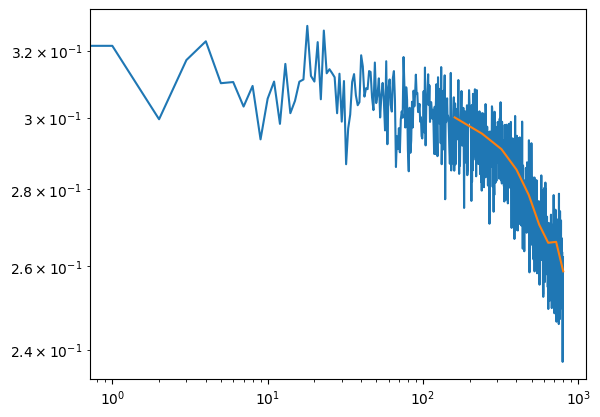

In [10]:
plt.plot((loss[2:]))
plt.plot(lossEval[1:,0],(lossEval[1:,1]))
plt.xscale('log')
plt.yscale('log')
plt.show()